In [1]:
import sys, os

from h5flow.data import dereference

layout_file = 'geo/layout-2.4.0.yaml'

vdrift = 1.5136504594138773 # mm/us for 0.5kV/cm

In [2]:
from collections import defaultdict
import yaml
import numpy as np

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from collections import defaultdict

import plotly.graph_objects as go
import plotly.express as px

import pandas as pd

import matplotlib.pyplot as plt
import glob
import itertools

from ROOT import TCanvas, TGraph, TF1, TProfile, TFile, TTree, TLegend, gROOT, gStyle, TH2D


Welcome to JupyROOT 6.22/09


In [3]:
gStyle.SetTitleFontSize(0.06)
gStyle.SetLabelSize(0.05,"xyz")
gStyle.SetTitleSize(0.05,"xyz")
gStyle.SetPadLeftMargin(0.16)
gStyle.SetPadRightMargin(0.16)
gStyle.SetPadBottomMargin(0.12)
gStyle.SetOptStat(0)

In [4]:
def load_tile_geometry(fpath):
    '''
    Build a dictionary for position lookup from tile layout.
 
    Arguments
    ---------
    fpath : str
        file path to the tile layout
    
    Returns
    -------
    geometry : dict
        dictionary of tile position in mm
        `geometry[(chip, channel)] -> (x,y,z)`   
    '''
    with open(fpath, 'r') as f:
        geometry_yaml = yaml.load(f, Loader=yaml.FullLoader)
          
    chips = geometry_yaml["chips"]
    pixels = geometry_yaml["pixels"]

    geometry = defaultdict(lambda: (None, None, None))
    
    for chip, channels in chips:
        for channel_id, channel in enumerate(channels):
            if channel is not None:
                x = pixels[channel][1]
                y = pixels[channel][2]
                z = 0
                geometry[(chip, channel_id)] = x, y, z

    return dict(geometry)


geom = load_tile_geometry(layout_file)

In [5]:
## size of the detector in [mm]
#### set boundary at the edge of the LArPix, not the inner boundary of the fieldshell
#### set z boundary loosely at 0, 300 mm
pixel_pitch = 4.43399

pos = np.array(list(geom.values())) 
x_min = pos[:, 0].min() - 0.5 * pixel_pitch
x_max = pos[:, 0].max() + 0.5 * pixel_pitch
abs_x_max = abs(pos[:, 0].max() + 0.5 * pixel_pitch)

y_min = pos[:, 1].min() - 0.5 * pixel_pitch
y_max = pos[:, 1].max() + 0.5 * pixel_pitch  
abs_y_max = abs(pos[:, 1].max() + 0.5 * pixel_pitch)

z_min = 0
z_max = 300

edge = [x_min, x_max, y_min, y_max, z_min, z_max]

In [6]:
print((x_max - x_min + pixel_pitch) / (pixel_pitch*2))
print((z_max - z_min) / (pixel_pitch*2))

35.50007780802392
33.829575619250384


In [7]:
cathode_crosser = False
trk_ends = np.load(f"data/2022-08/track_ends_edge_22-07_22-08_cathode_crossers_{cathode_crosser}.npy",allow_pickle=True)

Info in <TCanvas::Print>: pdf file plots/2022-08/x_true - x_reco [mm] @ x_min_track_ends_22-07_22-08_cathode_crossers_False_count.pdf has been created
Info in <TCanvas::Print>: pdf file plots/2022-08/x_true - x_reco [mm] @ x_min_track_ends_22-07_22-08_cathode_crossers_False.pdf has been created
Info in <TCanvas::Print>: pdf file plots/2022-08/x_true - x_reco [mm] @ x_max_track_ends_22-07_22-08_cathode_crossers_False_count.pdf has been created
Info in <TCanvas::Print>: pdf file plots/2022-08/x_true - x_reco [mm] @ x_max_track_ends_22-07_22-08_cathode_crossers_False.pdf has been created
Info in <TCanvas::Print>: pdf file plots/2022-08/y_true - y_reco [mm] @ y_min_track_ends_22-07_22-08_cathode_crossers_False_count.pdf has been created
Info in <TCanvas::Print>: pdf file plots/2022-08/y_true - y_reco [mm] @ y_min_track_ends_22-07_22-08_cathode_crossers_False.pdf has been created
Info in <TCanvas::Print>: pdf file plots/2022-08/y_true - y_reco [mm] @ y_max_track_ends_22-07_22-08_cathode_cro

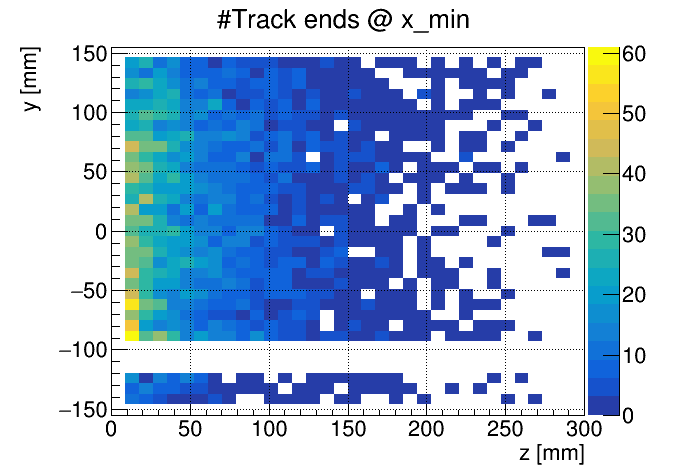

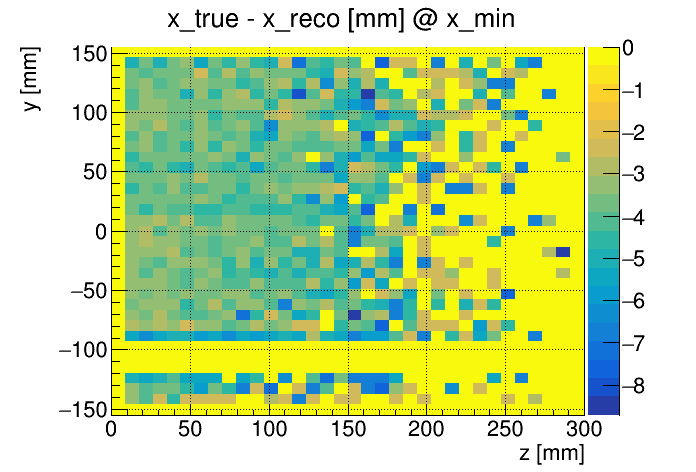

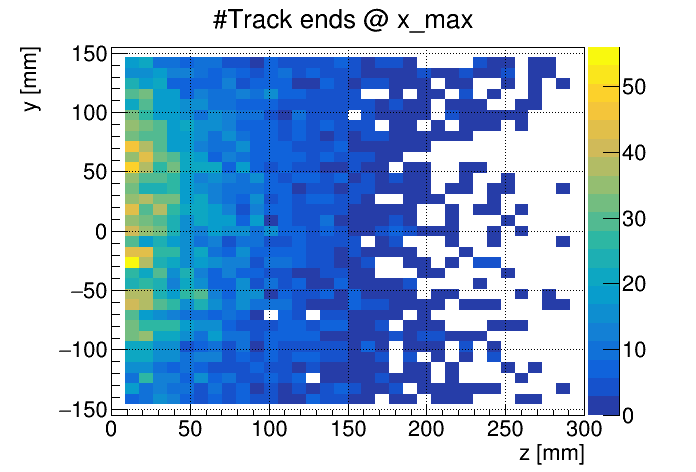

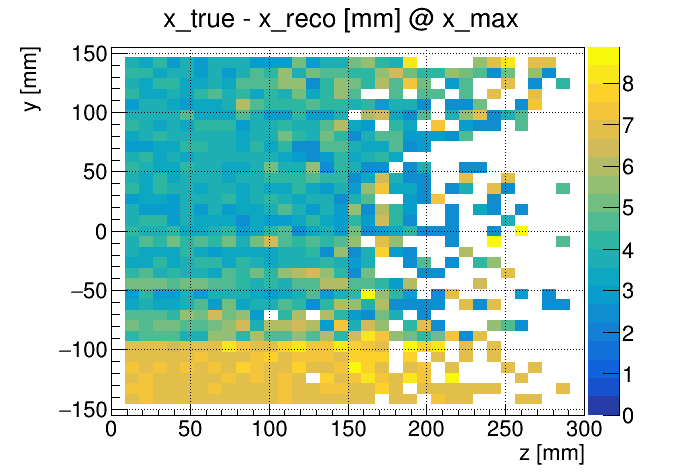

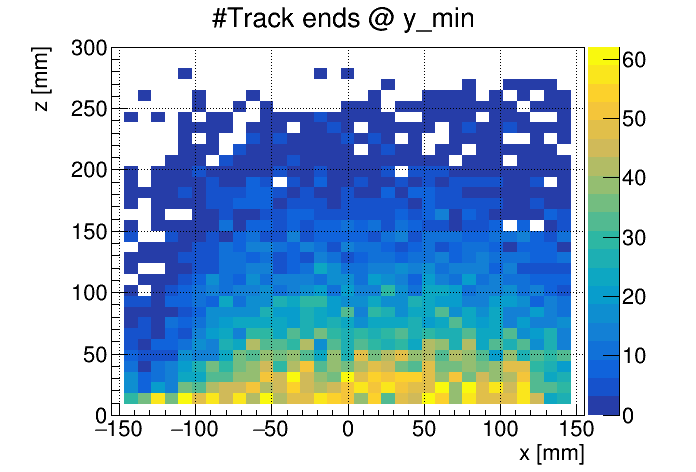

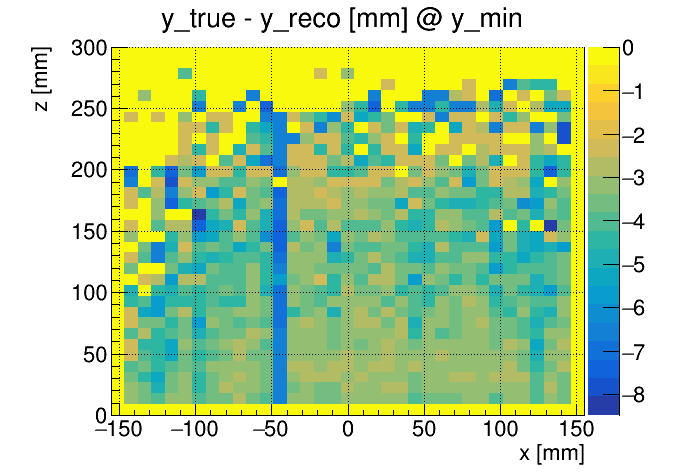

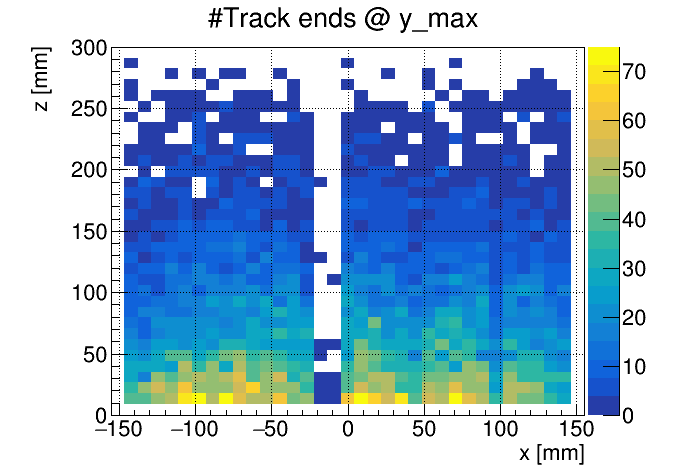

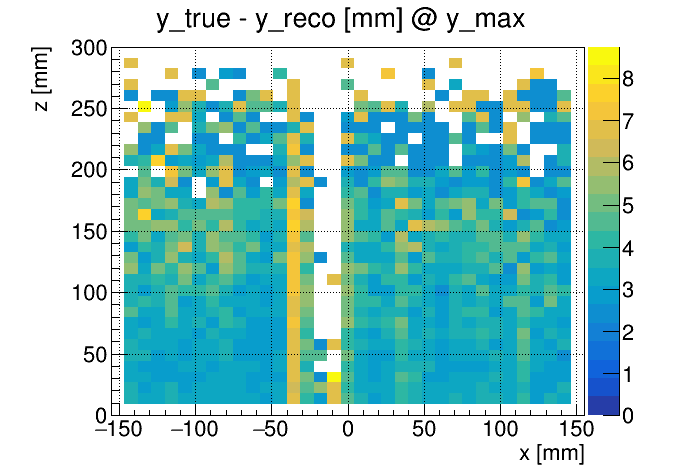

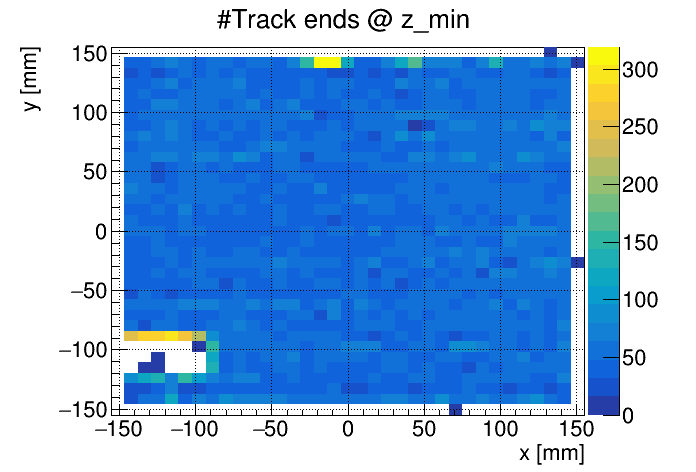

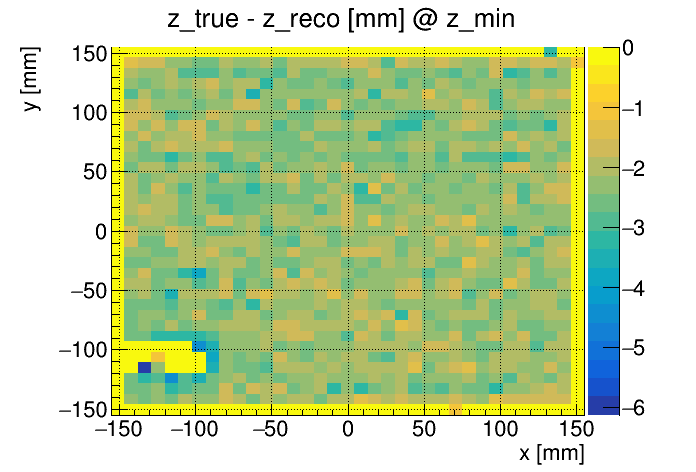

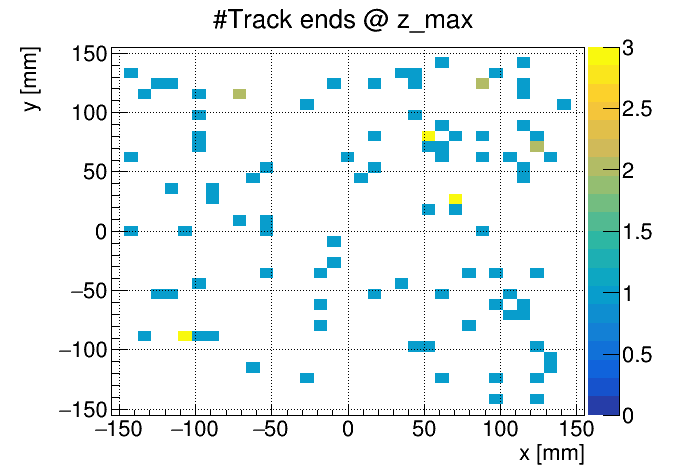

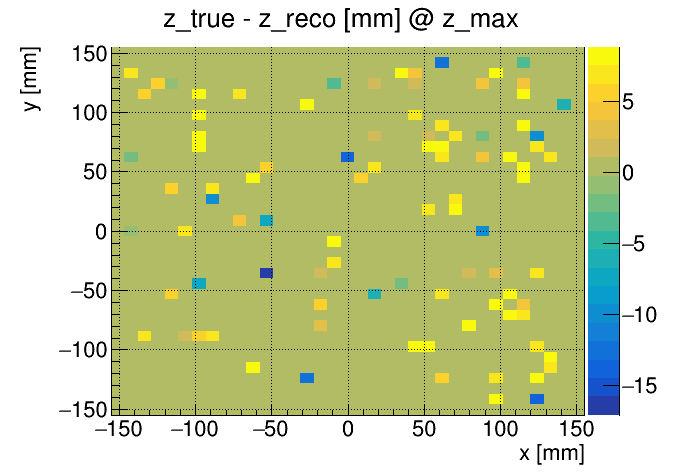

In [8]:
h_face = [None] * 6
h_face_count = [None] * 6
c = [None] * 6
cc = [None] * 6

edge_min = [x_min, y_min, z_min]
edge_max = [x_max, y_max, z_max]

nbins = [35, 35, 34] # x,y,z

axis_title = ["x [mm]", "y [mm]", "z [mm]"]

xyz_h = [2,0,0]
xyz_v = [1,2,1]


title = ["x_true - x_reco [mm] @ x_min", "x_true - x_reco [mm] @ x_max", "y_true - y_reco [mm] @ y_min", "y_true - y_reco [mm] @ y_max", "z_true - z_reco [mm] @ z_min", "z_true - z_reco [mm] @ z_max"]
title_count = ["#Track ends @ x_min", "#Track ends @ x_max", "#Track ends @ y_min", "#Track ends @ y_max", "#Track ends @ z_min", "#Track ends @ z_max"]

for i_face in range(6):
    idx_xyz = int(i_face / 2)
    i_h = xyz_h[idx_xyz]
    i_v = xyz_v[idx_xyz]
   
    h_face[i_face] = TH2D(f"h_face[{i_face}]", title[i_face], nbins[i_h], edge_min[i_h], edge_max[i_h], nbins[i_v], edge_min[i_v], edge_max[i_v])
    h_face_count[i_face] = TH2D(f"h_face_count[{i_face}]", title_count[i_face], nbins[i_h], edge_min[i_h], edge_max[i_h], nbins[i_v], edge_min[i_v], edge_max[i_v])

    if i_face % 2 == 0:
        for end in trk_ends[i_face]:
            h_face[i_face].Fill(end[i_h],end[i_v], (edge_min[idx_xyz] - end[idx_xyz]))    
            h_face_count[i_face].Fill(end[i_h],end[i_v])
    elif i_face % 2 == 1:
        for end in trk_ends[i_face]:
            h_face[i_face].Fill(end[i_h],end[i_v], (edge_max[idx_xyz] - end[idx_xyz]))    
            h_face_count[i_face].Fill(end[i_h],end[i_v])
    
    cc[i_face] = TCanvas( f'cc_{i_face}', '', 200, 10, 700, 500 )
    cc[i_face].SetGrid()
    cc[i_face].cd() 
    
    h_face_count[i_face].Draw("colz")
    h_face_count[i_face].GetXaxis().SetTitle(axis_title[i_h])
    h_face_count[i_face].GetYaxis().SetTitle(axis_title[i_v])
    
    cc[i_face].Update()
    cc[i_face].Draw("COLZ")
    cc[i_face].SaveAs(f"plots/2022-08/{title[i_face]}_track_ends_22-07_22-08_cathode_crossers_{cathode_crosser}_count.pdf")
    
    
    c[i_face] = TCanvas( f'c_{i_face}', '', 200, 10, 700, 500 )
    c[i_face].SetGrid()
    c[i_face].cd() 
    
    h_face[i_face].Divide(h_face_count[i_face])
    h_face[i_face].Draw("colz")
    h_face[i_face].GetXaxis().SetTitle(axis_title[i_h])
    h_face[i_face].GetYaxis().SetTitle(axis_title[i_v])
    
    c[i_face].Update()
    c[i_face].Draw("COLZ")
    c[i_face].SaveAs(f"plots/2022-08/{title[i_face]}_track_ends_22-07_22-08_cathode_crossers_{cathode_crosser}.pdf")
    